In [1]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm

In [2]:

# Load price data
eth_df = pd.read_csv('data/ETH-USD.csv', parse_dates=['Date'])
eth_df = eth_df.sort_values(by='Date')
eth_df.set_index('Date', inplace=True)

In [3]:

# Calculate returns
eth_df['SimpleReturns'] = eth_df['Adj Close'].pct_change()
eth_df['CumReturns'] = ((1+eth_df['SimpleReturns']).cumprod() - 1) * 100

In [4]:
eth_df.head()

,Open,High,Low,Close,Adj Close,Volume,SimpleReturns,CumReturns
Date,,,,,,,,
2020-11-26,570.514893,575.641479,485.497314,518.801147,518.801147,31104004592,NaN,NaN
2020-11-27,519.108093,530.777161,497.242615,517.493713,517.493713,16831105703,-0.002520,-0.252011
2020-11-28,517.597351,548.044861,508.125366,538.229797,538.229797,14770243833,0.040070,3.744913
2020-11-29,538.264587,576.602417,531.987549,575.758057,575.758057,15017517758,0.069725,10.978563
2020-11-30,575.757080,615.240540,571.537781,614.842529,614.842529,20276867833,0.067883,18.512176


# Tail Risk

Tail risk is the quantifiable level of risk that can be attributed to extreme investment outcomes. We are particularly interested in the tail risk that can occur on the left (negative) side of a distribution.

<img src='tail_risks.png'>

Image from https://seekingalpha.com/article/4225841-dancing-swans-tail-risks

# Historical Drawdown

In [5]:

# Historical drawdown estimates the percentage loss from the previous highest point of the portfolio
# How far have you fallen from your highest historical point?
cum_returns = eth_df['CumReturns'].dropna()
running_max = np.maximum.accumulate(cum_returns)
running_max[running_max < 1] = 1
drawdown = (cum_returns)/running_max - 1
print("The maximum drawdown was {:.2f}".format(np.amin(drawdown[drawdown > -1] * 100))+"%.")

The maximum drawdown was -72.43%.


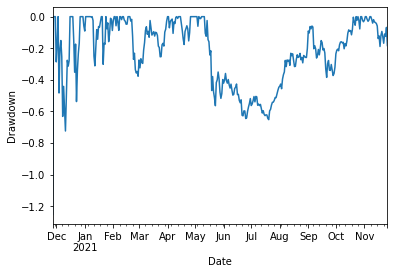

In [6]:
drawdown.plot()
plt.ylabel('Drawdown')
plt.show()

# Value at Risk & Conditional Value at Risk

In [7]:

# Value at Risk (VaR) is an estimate of how much could be lost in a given time period, within a given confidence level
# How much could be lost during a given period historically? And how confident can we be of that historical estimate?
# Daily Var at 95% confidence level estimated below, since this is based on daily historical data
# Commonly quoted with quantiles such as 95, 99 and 99.9%
confidence_level = 95
simple_returns_perc = eth_df['SimpleReturns'].dropna()*100
v_a_r = np.percentile(simple_returns_perc, 100-confidence_level)
print("VaR("+str(confidence_level)+"): {:.2f}".format(v_a_r)+"%.")

VaR(95): -8.03%.


In [8]:

# Conditional Value at Risk (CVaR) is an estimate of the expected value of losses sustained on the occassions when the worst x% of scenarios happened
# In the worst x% of scenarios, how much on average could we have lost historically?
# Also known as Expected Shortfall, it will always be lower than Var
# CVaR at 95% confidence level estimated below, based on above VaR
c_v_a_r = simple_returns_perc[simple_returns_perc <= v_a_r].mean()
print("CVaR("+str(confidence_level)+"): {:.2f}".format(c_v_a_r)+"%.")

CVaR(95): -11.95%.


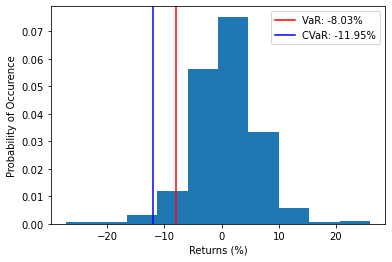

In [9]:

# Plot Var and CVar
sorted_returns = sorted(simple_returns_perc)
plt.hist(sorted_returns, density=True)
plt.axvline(x=v_a_r, color='r', linestyle='-', label='VaR: {0:.2f}%'.format(v_a_r))
plt.axvline(x=c_v_a_r, color='b', linestyle='-', label='CVaR: {0:.2f}%'.format(c_v_a_r))
plt.ylabel('Probability of Occurence')
plt.xlabel('Returns (%)')
plt.legend()
plt.show()

In [18]:

# Above estimations use empirical observations. What if a some loss never occured?
# A better approach would be to sample from a probability distribution
# Assume returns normally distributed, calculate Parametric VaR
simple_returns = eth_df['SimpleReturns'].dropna()
mu = np.mean(simple_returns)
vol = np.std(simple_returns)
p_v_a_r = norm.ppf((100-confidence_level)/100, mu, vol)
print("PVaR("+str(confidence_level)+"): {:.2f}".format(p_v_a_r*100)+"%.")

PVaR(95): -8.58%.


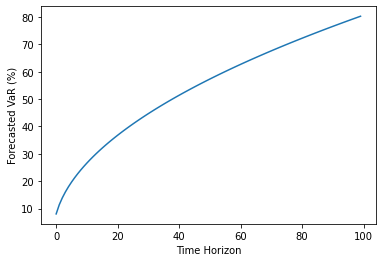

In [24]:

# plot scaled VaR estimate curve for the next 100 days
forecasted_values = np.empty([100,2])
for i in range(0, 100):
    forecasted_values[i,0] = i
    forecasted_values[i,1] = v_a_r*np.sqrt(i+1)
    
plt.plot(forecasted_values[:,0], forecasted_values[:,1]*-1)
plt.xlabel("Time Horizon")
plt.ylabel('Forecasted VaR (%)')
plt.show()

# Monte Carlo Simulation